# Infer ***endoplasmic reticulum*** - part 8️⃣

--------------

OBJECTIVE:  ✅ Infer sub-cellular component ***endoplasmic reticulum*** (***ER***) in order to understand interactome 



Dependencies:
The ***ER***  inference rely on the cytosol mask.



## IMPORTS

In [7]:
# top level imports
from pathlib import Path
import os, sys

import numpy as np

from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.vessel import filament_2d_wrapper
                                                 
from skimage.measure import label


import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc_2d.utils.img import *

from infer_subc_2d.organelles import fixed_infer_soma_MCZ, fixed_infer_nuclei, infer_cytosol


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [9]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [10]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK


In [11]:
# nuclei_fname = "/Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"

cytosol_mask = import_inferred_organelle("cytosol", meta_dict, out_data_path)

if cytosol_mask is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    soma = fixed_infer_soma_MCZ(img_data, nuclei)
    nucleus_obj =  apply_mask(nuclei, soma) 
    cytosol_mask =  infer_cytosol(soma, nucleus_obj, erode_nuclei=False) 
    out_file_n = export_inferred_organelle(cytosol_mask, "cytosol", meta_dict, out_data_path)
    print(f"calculated cytosol mask. wrote {out_file_n}")
else:
    print(f"loaded cytosol mask from {out_data_path}")


loaded cytosol mask from /Users/ahenrie/Projects/Imaging/data/out


---------------------

## infer ***endoplasmic reticulum***

## summary of steps 

INPUT
- ch 6
- cytosol mask

PRE-PROCESSING
- edge preserving scaling

CORE-PROCESSING
- vesselness slice-by-slice

POST-PROCESSING
  - S  - remove objects less than 2x2 pixels (area = 4)

OUTPUT
- object **er** 


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

>sec61beta  is  good start for ER  as per from [Allen Cell](https://www.allencell.org/cell-observations/category/endoplasmic-reticulum).    

using [seg_sec61b.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aics-segmentation/aicssegmentation/structure_wrapper/seg_sec61b.py)
[seg_sec61b_dual.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_sec61b_dual.py)

[playground_Sec61b.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_Sec61b.ipynb)



## INPUT prototype

In [12]:
###################
# INPUT
###################
# raw_er   = img_2D[ER_CH].copy()
raw_er = select_channel_from_raw(img_data, ER_CH)


## PRE-PROCESSING prototype

In [13]:
###################
# PRE_PROCESSING
###################
# struct_img = normalized_edge_preserving_smoothing( raw_er)

median_sz = 0
gauss_sig = 3.0

struct_img =  scale_and_smooth(raw_er,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)


## CORE PROCESSING prototype

In [14]:
###################
# CORE_PROCESSING
###################

################################
## PARAMETERS for this step ##
f2_param = [[1, 0.15]]
################################

bw = filament_2d_wrapper(struct_img, f2_param)

## POST-PROCESSING prototype

In [15]:

###################
# POST_PROCESSING
###################
################################
## PARAMETERS for this step ##
small_object_width = 4
################################
er_object = size_filter_linear_size(bw, 
                                                min_size= small_object_width)

# ################################
# ## PARAMETERS for this step ## from seg_sec61b.py
# min_area = 15
# ################################
# bw = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)
# # prune slice by slice
# for zz in range(bw.shape[0]):
#     bw[zz, :, :] = remove_small_objects(bw[zz, :, :], min_size=3, connectivity=1, in_place=False)

# ER_object = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [16]:
viewer = napari.Viewer()


In [18]:

viewer.add_image(
    bw,
)


viewer.scale_bar.visible = True
viewer.add_image(
    struct_img
)

viewer.add_image(
    er_object,
)

<Image layer 'er_object' at 0x14493f5b0>

## DEFINE `infer_endoplasmic_reticulum` function

Based on the _prototyping_ above define the function to infer the er.  


In [19]:
##########################
#  infer_endoplasmic_reticulum
##########################
def _infer_endoplasmic_reticulum(
                                in_img: np.ndarray,
                                gauss_sig: float,
                                filament_scale : float,
                                filament_cut : float,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    er_ch = ER_CH
    ###################
    # EXTRACT
    ###################    
    er = select_channel_from_raw(in_img, er_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    # er = normalized_edge_preserving_smoothing(er)
    struct_img =  scale_and_smooth(er,
                                                    median_sz = 0, 
                                                    gauss_sig = gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    # f2_param = [[filament_scale, filament_cut]]
    # # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
    # struct_obj = filament_2d_wrapper(er, f2_param)
    struct_obj = filament_filter(er, filament_scale, filament_cut)

    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = size_filter_linear_size(struct_obj, 
                                                    min_size= small_obj_w)

    return struct_obj



# TEST  `_fixed_infer_endoplasmic_reticulum` function

In [20]:
##########################
#  fixed_infer_endoplasmic_reticulum
##########################
def _fixed_infer_endoplasmic_reticulum(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer endoplasmic rediculum from linearly unmixed input with *fixed parameters*

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    gauss_sig = 3
    filament_scale = 1
    filament_cut = 0.15
    small_obj_w = 2 
    return _infer_endoplasmic_reticulum(  in_img,
                                gauss_sig,
                                filament_scale,
                                filament_cut ,
                                small_obj_w)
    
    

# TEST  `_infer_endoplasmic_reticulum` function

In [21]:

_er_object =  _fixed_infer_endoplasmic_reticulum(img_data) 


In [22]:
from infer_subc_2d.organelles import fixed_infer_endoplasmic_reticulum

er_object =  fixed_infer_endoplasmic_reticulum(img_data) 


## Visualize  2


In [23]:

viewer.add_image(
    er_object,
)
viewer.add_labels(
    label(er_object),
)


viewer.add_image(
    _er_object,
)

<Image layer '_er_object' at 0x13f4475e0>

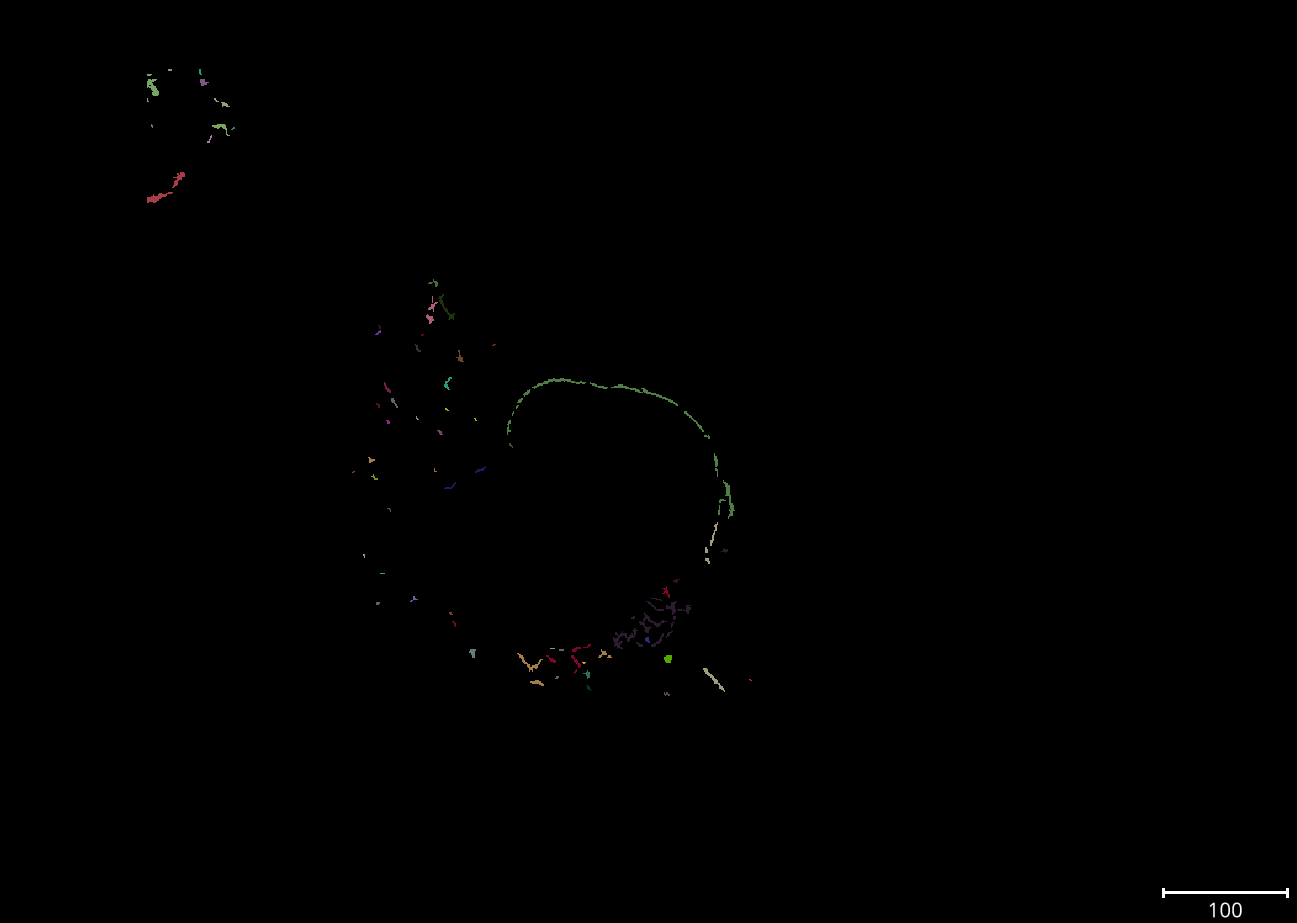

In [24]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [25]:
viewer.close()

-----------------
Write the `infer_endoplasmic_reticulum` spec to the widget json 

In [22]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_er =  {
        "name": "infer endoplasmic reticulum  (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_endoplasmic_reticulum",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_er",_fixed_infer_er, overwrite=True)

function fixed_infer_er is already in all_functions.json
overwriting  fixed_infer_er


1

In [23]:

_infer_er =  {
        "name": "Infer Endoplasmic Reticulum",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_endoplasmic_reticulum",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_er", _infer_er, overwrite=True )



function infer_er is already in all_functions.json
overwriting  infer_er


1

##  helper function definitions

Wrappers for vessleness filters

In [24]:

_filament_filter =  {
        "name": "filament filter thresholding",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "filament_filter",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
        }
}

add_function_spec_to_widget_json("filament_filter", _filament_filter, overwrite=True )



function filament_filter is already in all_functions.json
overwriting  filament_filter


1

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [25]:
from infer_subc_2d.constants import ER_CH
def make_infer_er_step_by_step_from_raw_dict():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = ER_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("edge_preserving_smoothing")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(6)

    step_name.append("8")
    function_name.append("filament_filter") 
    category.append("core")
    parameter_values.append( dict( filament_scale=1., filament_cut=.15) )
    parent.append(7)

    step_name.append("9")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([8,4])

    step_name.append("10")
    function_name.append("size_filter_linear_size")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 2**2  ))
    parent.append(9)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [26]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_er_stepbystep_from_raw_dict = make_infer_er_step_by_step_from_raw_dict()

write_workflow_json("conf_1.8.er_stepbystep_from_raw", infer_er_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.8.er_stepbystep_from_raw.json')

In [27]:
viewer.close()

-------------
## SUMMARY

The above details how the endoplasmic reticulum object is inferred.  

### NEXT: INFER LIPID BODY

proceed to [09_infer_lipid_body.ipynb](./09_infer_lipid_body.ipynb)
